<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span></li><li><span><a href="#Selecting-Sig-Data" data-toc-modified-id="Selecting-Sig-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Selecting Sig Data</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plots</a></span></li><li><span><a href="#Plot-Testing" data-toc-modified-id="Plot-Testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot Testing</a></span></li></ul></div>

# Preamble

In [1]:
##############################
''' Packages '''
%matplotlib inline

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from dask.diagnostics import ProgressBar
# ProgressBar().register()
import dask.array
import cartopy.crs as ccrs
import pickle
import matplotlib.colors as colors
import datetime as dt
rb = plt.cm.RdBu
bm = plt.cm.Blues

import warnings
warnings.filterwarnings('ignore')

In [2]:
directory = '/home/student.unimelb.edu.au/aborowiak/Desktop/Code/Scripts/MJO/Station/int_data/'
save_dir = '/home/student.unimelb.edu.au/aborowiak/Desktop/Code/Scripts/MJO/Station/int_plot/'

In [3]:
path = '/home/student.unimelb.edu.au/aborowiak/Desktop/Code/Scripts/MJO/RMM.pickle'
pickle_in = open(path, 'rb')
RMM = pickle.load(pickle_in)

RMM = RMM.reset_index()
RMM = RMM.rename({'Date':'time'}, axis = 1)
RMM = RMM.set_index(['time'])

In [4]:
path = '/home/student.unimelb.edu.au/aborowiak/Desktop/Code/Scripts/MJO/Station/station_xr.nc'
MJO_station = xr.open_mfdataset(path)
station_xr = MJO_station.sel(time = slice(RMM.index[0], '2010'))

In [5]:
path = directory  + 'station_int_90.nc'
station_90 = xr.open_dataset(path)

In [6]:
path = directory  + 'station_int_95.nc'
station_95 = xr.open_dataset(path)

In [7]:
path = directory  + 'station_int_boot_90.nc'
station_boot_90 = xr.open_dataset(path)

In [25]:
station_boot_90

<xarray.Dataset>
Dimensions:     (location: 32, mjo: 2, month: 6, percentile: 2)
Coordinates:
  * month       (month) int64 1 2 3 10 11 12
  * location    (location) object '5004' '5008' '5014' '4006' '3028' '3030' ...
  * percentile  (percentile) object '90' '10'
  * mjo         (mjo) object 'enhanced' 'suppressed'
Data variables:
    precip      (mjo, percentile, location, month) float64 ...

In [8]:
path = directory  + 'station_int_boot_95.nc'
station_boot_95 = xr.open_dataset(path)

In [9]:
def correct_dataset(extreme, original):
    dataset = xr.Dataset({'precip':(('mjo','location','month'),np.array(extreme.frac.values)),
                         'station_name':(('location'), original.station_name),
                          'lat':(('location'), original.lat),
                         'lon':(('location'), original.lon)
                         },
                         {'mjo': ['enhanced', 'suppressed', 'inactive'], 'location':original.location, 'month':
                         [10,11,12,1,2,3]}
                        )
    return dataset
    

In [10]:
station_90 = correct_dataset(station_90, station_xr)

# Selecting Sig Data

In [11]:
# THis function return an array that contains only values for the signficant points

def sel_sig(normal, boot):
    
    
    # The enhanced phase where we only want the points that are greater than 1
    name = 'enhanced'
    normal_en = normal.sel(mjo = name)
    boot_en = boot.sel(mjo = name)
    
    station_sig_en = normal_en.precip.where(
    np.logical_and(
        boot_en.isel(percentile = 0).precip >= 1, 
        boot_en.isel(percentile = 1).precip >= 1)
        )
    
    # The suppressed phase where we only want the points that are less than 1
    name = 'suppressed'
    normal_sup = normal.sel(mjo = name)
    boot_sup = boot.sel(mjo = name)
    
    station_sig_sup = normal_sup.precip.where(
    np.logical_and(
        boot_sup.isel(percentile = 0).precip <= 1, 
        boot_sup.isel(percentile = 1).precip <= 1)
    )
    
        
    station_sig =  xr.concat([station_sig_en, station_sig_sup], pd.Index(['enhanced','suppressed'], name = 'mjo'))
    
    return station_sig

In [16]:
station_90_sig = sel_sig(station_90, station_boot_90)


station_90_sig = station_90_sig.assign_coords(lat = station_90.lat)
station_90_sig = station_90_sig.assign_coords(lon = station_90.lon)

# Plots

In [17]:
class MidpointNormalizeLog(colors.LogNorm):
    def __init__(self, vmin, vmax, midpoint):
        self.midpoint = midpoint
        super().__init__(vmin=vmin, vmax=vmax)
        
    def __call__(self, value, clip=None):
        original = super().__call__(value, clip)
        procmid = super().__call__(self.midpoint, clip)
        
        x, y = [0, procmid, 1], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(original, x, y), np.isnan(original))

In [18]:
import datetime as dt

In [77]:
def plot_sig_and_norm(data_all_sub, data_sig_sub, ax):
    
    
    vmax = 2.5
    vmin = 0.5
    size = 200
    
    # Plotting all the points
  
    plot_data = plt.scatter(data_all_sub.lon.values,data_all_sub.lat, s = size,c = data_all_sub.precip,
                            edgecolor = 'k', cmap = rb,
                norm =  MidpointNormalizeLog(vmin = vmin, vmax = vmax, midpoint=1))
    

    # Now for the significant we want to drop all the points that aren't significant, and then plot just an 'x'
    
    data_sig_sub = data_sig_sub.dropna(dim = 'location')
    plt.scatter(data_sig_sub.lon.values,data_sig_sub.lat, s = size - 75, c = 'k', marker = 'x')

    # Coastlines
#     ax.coastlines()
    ax.coastlines(resolution  = '50m')
  
    
    
    return plot_data

In [82]:
def station_plot(data_all, data_sig, save_fig, title = ''):
    fig = plt.figure(figsize  = (12,8), dpi = 400)
    
   
    
    month_name = dt.date(2015, int(month), 1).strftime('%B')
    title = str(month_name) + " : " 
    title_size =15
    fig.suptitle(title, fontsize = title_size)

    
    plot_num = 1
    # Plotting the enhanced phase
    name = 'enhanced'
    
    ax = fig.add_subplot(2,1,plot_num,projection = ccrs.PlateCarree())

    data_all_sub = data_all.sel(mjo = name)
    data_sig_sub = data_sig.sel(mjo = name)
    _ = plot_sig_and_norm(data_all_sub, data_sig_sub, ax)
    
    
    # Plotting the suppressed phase
    plot_num += 1
    name = 'suppressed'
    
    ax = fig.add_subplot(2,1,plot_num,projection = ccrs.PlateCarree())

    data_all_sub = data_all.sel(mjo = name)
    data_sig_sub = data_sig.sel(mjo = name)
    plot_data = plot_sig_and_norm(data_all_sub, data_sig_sub, ax)
    
    ###### Row Labels
#     plt.text(100,1,'hello')
    
    xdip = 106
    plt.text(xdip,-4,'Enhanced', fontsize = title_size )
    plt.text(xdip,-18,'Suppressed', fontsize = title_size )
    
    
    
    ###### Color Bar

    ticks= np.array([0.5,0.75,1,1.25,1.5,2])
    tick_labels = [str(i) for i in ticks]
    ticks = ticks - 0.05
    step = 0.1
#     boundaries = np.arange(0.1,vmax - step,step)
    cax = fig.add_axes([.3, 0.9, 0.4,0.01])

    cbar = plt.colorbar(plot_data, orientation = 'horizontal', ticks= ticks, cax = cax,
                           extend = 'both')

    cbar.ax.set_xticklabels(tick_labels); 
    cbar.set_label('Ratio'
                  , fontsize = 12, labelpad = 10) 
    
    
    
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.83])
    

    if save_fig:
        fig.savefig(save_dir + title + '.png', dpi = 400)

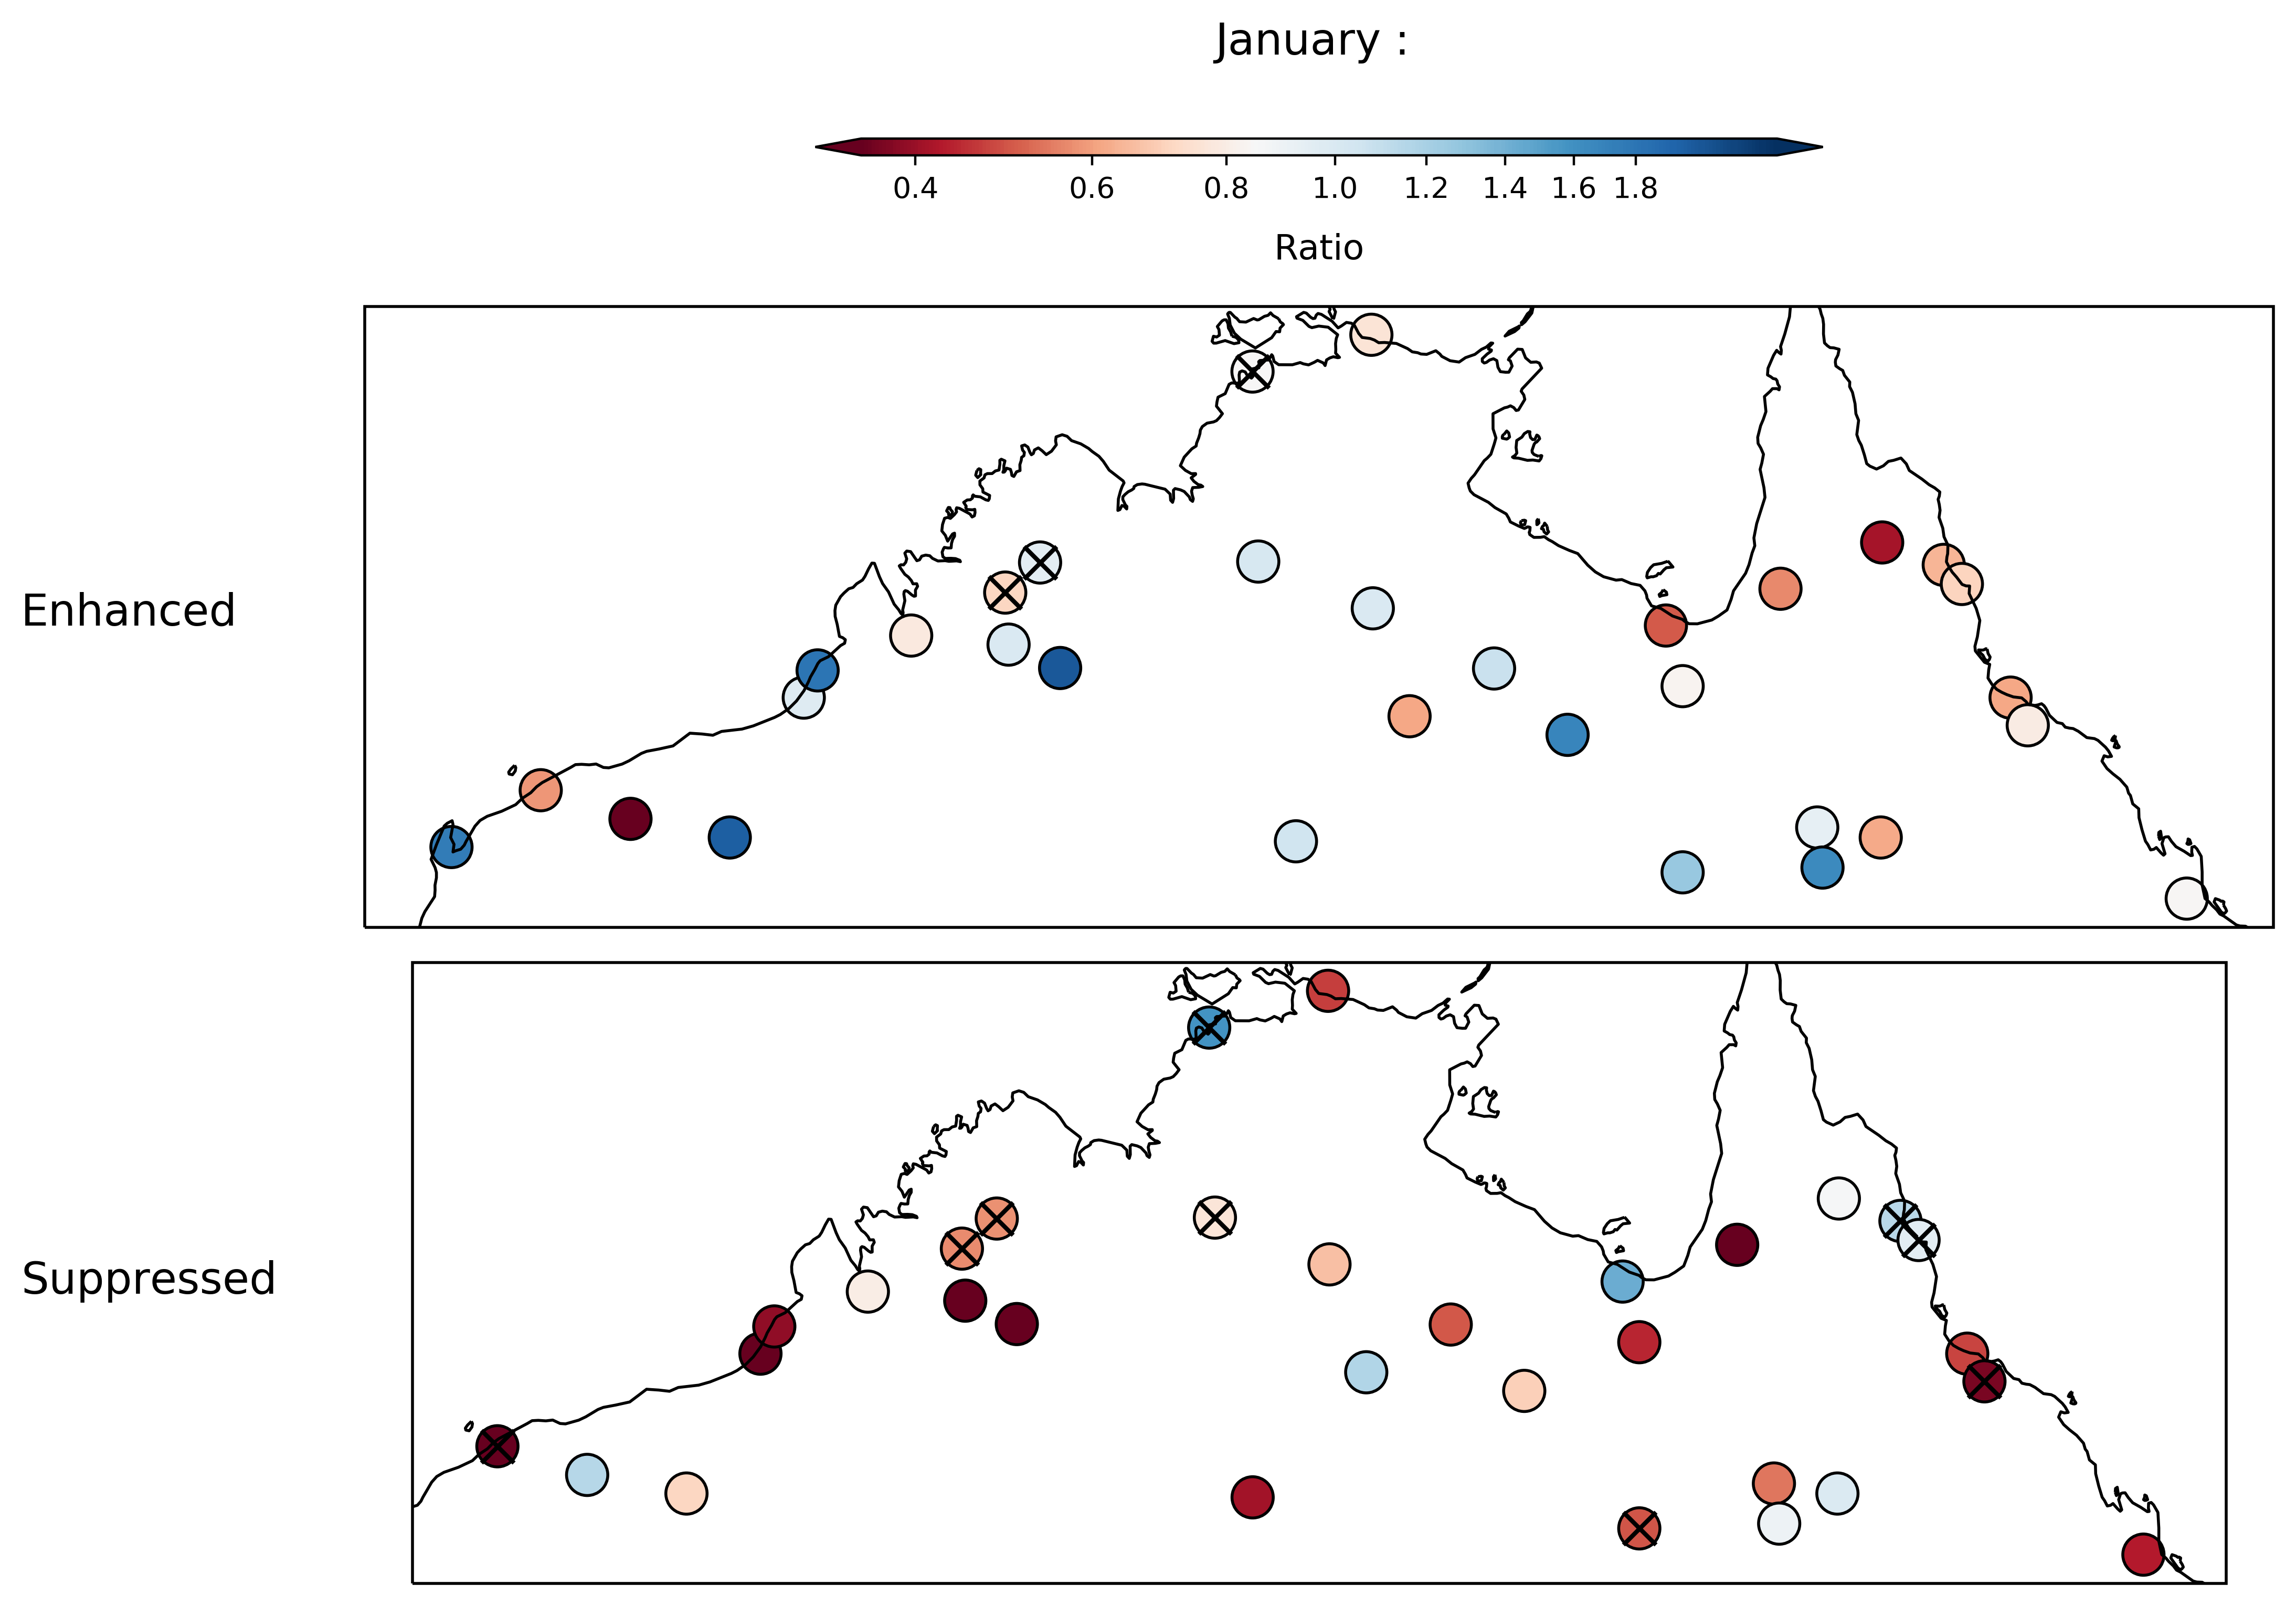

In [85]:

month = 1
title = 'Intensity'
data_all = station_90.sel(month = month)
data_sig = station_90_sig.sel(month = month)
save_fig = 0
station_plot(data_all, data_sig, title, save_fig)

# Plot Testing

In [27]:
# Analysis 
import xarray as xr
import numpy as np

# Plotting 
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as mticker
import matplotlib.colors as colors

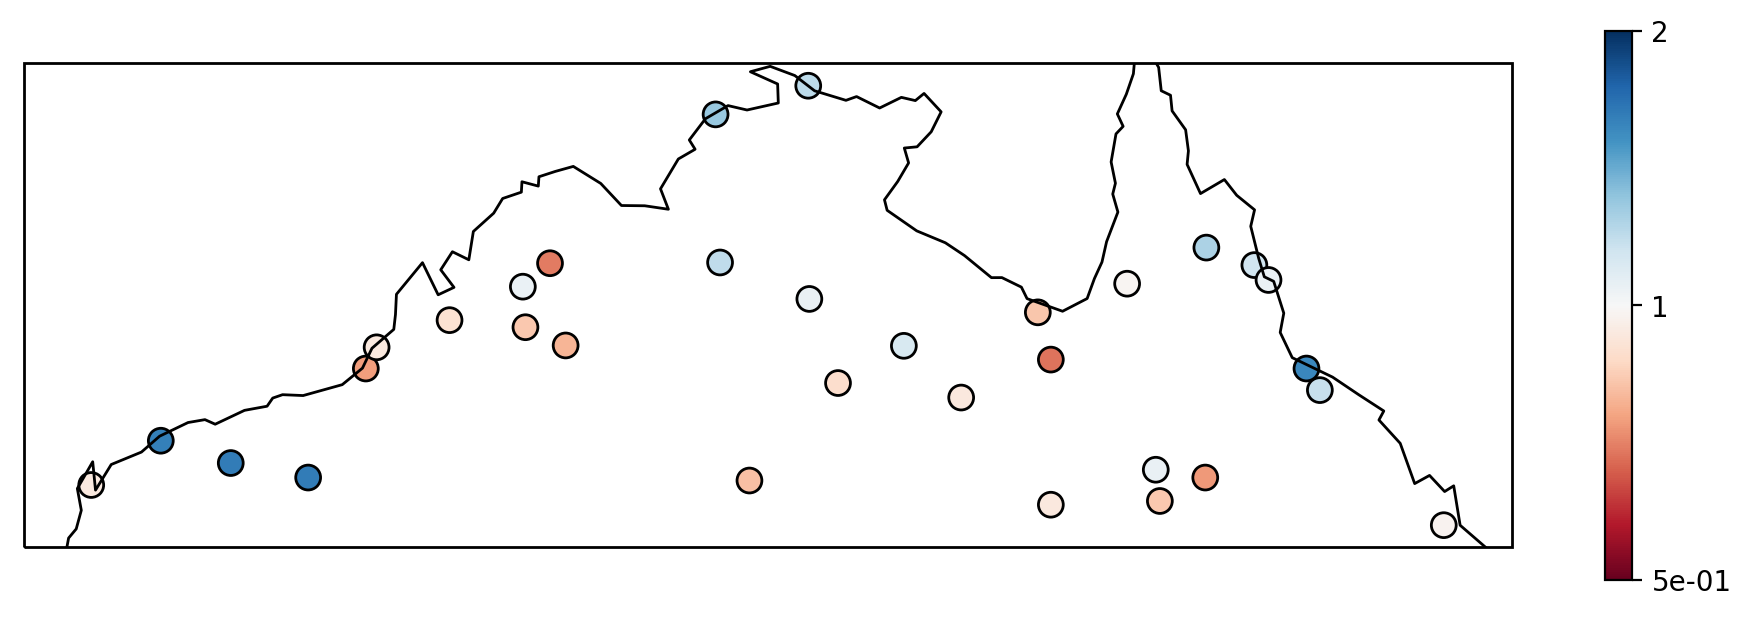

In [64]:
fig = plt.figure(figsize  = (12,8), dpi = 200)
ax = fig.add_subplot(2,1,1,projection = ccrs.PlateCarree())
month = 12
size = 80
data_sub = station_90.sel(month = month, mjo = 'enhanced')


# cmap = plt.get_cmap('RdBu', 8) 

cmap = plt.get_cmap('RdBu')
max_exp = 1
plot_data = plt.scatter(data_sub.lon.values,data_sub.lat, s = size,c = data_sub.precip,marker='o', 
                        edgecolor = 'k', cmap=cmap, 
    norm=colors.SymLogNorm(
        vmin= 2 ** -max_exp, vmax= 2 ** max_exp,
        linthresh=2 ** -max_exp, linscale=1
    )
)

ax.coastlines()
# boundaries = [0.5,0.75,1,1.25,1.5,1.75,2]
# cbar = plt.colorbar(ticks = boundaries, boundaries = boundaries)
# cbar.ax.set_yticklabels([str(i) for i in boundaries]);


cbar = plt.colorbar()
cbar.locator     = mticker.SymmetricalLogLocator(base=2, linthresh = 2 ** -max_exp, )
cbar.formatter   = mticker.LogFormatter(base=2, minor_thresholds=(2,0.25))
 

cbar.update_ticks()


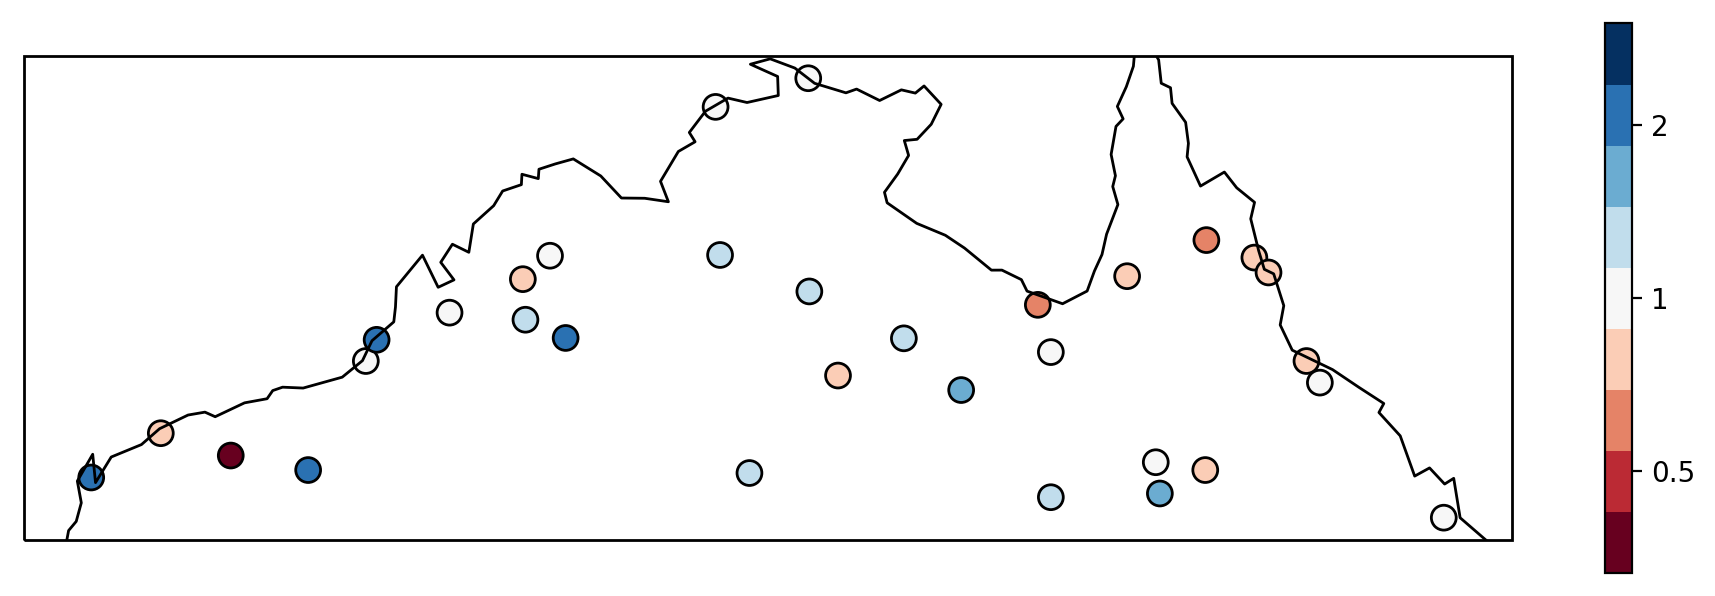

In [49]:
fig = plt.figure(figsize  = (12,8), dpi = 200)
ax = fig.add_subplot(2,1,1,projection = ccrs.PlateCarree())
month = 12
size = 80
data_sub = data_all.sel( mjo = 'enhanced')
vmin = 0.2
vmax= 2
# cmap = 'coolwarm'
# cmap = my_map
cmap = 'RdBu'
cmap = plt.get_cmap(cmap, 9) 

max_exp = 2
plot_data = plt.scatter(data_sub.lon.values,data_sub.lat, s = size,c = data_sub.precip,marker='o', 
                        edgecolor = 'k', cmap=cmap, 
    norm=colors.SymLogNorm(
        vmin= 1/3, vmax= 3 ,
        linthresh=2 ** -max_exp, linscale=1
    )
)

ax.coastlines()


ticks = [0.5, 1,2]
cbar = plt.colorbar(ticks = ticks)
cbar.ax.set_yticklabels([str(i) for i in ticks]);
# cbar = plt.colorbar()

# cbar.locator     = mticker.SymmetricalLogLocator(base=2, linthresh = 2 ** -max_exp, )
# cbar.formatter   = mticker.LogFormatter(base=2, minor_thresholds=(2,0.25))
 

# cbar.update_ticks()

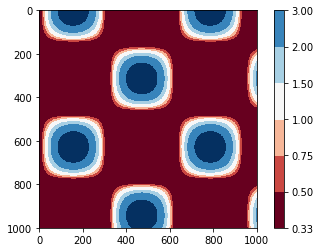

In [95]:

from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm


levels = [ 0.33, 0.5,0.75,1,1.5, 2,3]
cmap = "RdBu"
# cmap = "RdYlBu"
# cmap = 'coolwarm_r'
# cmap = 'seismic_r'


custom_RdBu = cm.get_cmap(cmap,len(levels))
cbar_ticks = levels[:]

x = np.linspace(0, 10, 1000)
I = 4* np.sin(x) * np.cos(x[:, np.newaxis])

norm = BoundaryNorm(levels, len(levels)-1)
plt.imshow(I, cmap = custom_RdBu,norm = BoundaryNorm(levels, len(levels)-1))
plt.colorbar()
plt.show()